# Implementation of Variational AutoEncoder (VAE)

     Code Modified from VAE from "Auto-Encoding Variational Bayes" (2014, D.P. Kingma et. al.) https://github.com/Jackson-Kang/Pytorch-VAE-tutorial


In [1]:
# Import necessary libraries for building and training the VAE model.
# torch: Core PyTorch library for tensor operations and neural networks.
# torch.nn: Module for neural network layers (e.g., Linear, LeakyReLU).
# numpy: Library for numerical operations, often used for data manipulation.
# torchvision.utils.save_image, make_grid: Utilities for saving and visualizing images from torchvision.
import torch
import torch.nn as nn
import numpy as np
from torchvision.utils import save_image, make_grid

In [13]:
# Model Hyperparameters

# Path to store or load the dataset. This should be adjusted based on your environment.
dataset_path = '/Users/jiankang/University of Michigan Dropbox/Jian Kang/Umich/Biostat682/Fall2025/data/'

# DEVICE specifies where the computations will run (CPU, CUDA for NVIDIA GPUs, or MPS for Apple Silicon GPUs).
# It's currently set to 'cpu' for broader compatibility.
# DEVICE = torch.device('mps') # Uncomment this line if you have an Apple Silicon GPU and want to use it.
DEVICE = torch.device('cpu') # Set to 'cuda' if you have an NVIDIA GPU and PyTorch is configured to use it.

# batch_size: Number of samples processed in each iteration during training.
batch_size = 100

# x_dim: Dimension of the input data (e.g., 28*28 = 784 for a flattened MNIST image).
x_dim  = 784
# hidden_dim: Dimension of the hidden layers in both the encoder and decoder.
hidden_dim = 400
# latent_dim: Dimension of the latent space (z) where the encoded representations reside.
latent_dim = 200

# lr: Learning rate for the Adam optimizer, controlling the step size during optimization.
lr = 1e-3

# epochs: Number of complete passes through the entire training dataset.
epochs = 30

###    Step 1. Load (or download) Dataset

In [12]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


# Define transformations to apply to the MNIST images.
# transforms.ToTensor(): Converts PIL Image or numpy.ndarray to torch.FloatTensor
#                       and scales the image pixel values to [0.0, 1.0].
mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

# kwargs: Dictionary for DataLoader additional arguments.
# num_workers: Number of subprocesses to use for data loading.
# pin_memory: If True, the data loader will copy Tensors into CUDA pinned memory before returning them.
#             Set to False as DEVICE is 'cpu', so pinned memory is not applicable/needed and avoids warnings.
kwargs = {'num_workers': 1, 'pin_memory': False}

# Load the MNIST dataset.
# train_dataset: Training set of MNIST images.
# test_dataset: Test set of MNIST images.
# dataset_path: Directory where the dataset will be stored.
# transform: The transformations defined above are applied.
# train=True/False: Specifies if it's the training or test set.
# download=True: Downloads the dataset if it's not already present.
train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

# Create DataLoaders for both training and test sets.
# DataLoader: Combines a dataset and a sampler, and provides an iterable over the dataset.
# batch_size: Defines the number of samples in each batch.
# shuffle=True: Shuffles the training data at each epoch for better generalization.
# shuffle=False: Test data is not shuffled.
# **kwargs: Unpacks the dictionary of additional arguments.
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

### Step 2. Define our model: Variational AutoEncoder (VAE)

In [4]:
'''
    A simple implementation of Gaussian MLP Encoder
    This Encoder maps the input data 'x' to the parameters (mean and log_variance)
    of a Gaussian distribution in the latent space.
'''

class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        # Initialize the parent nn.Module class.
        super(Encoder, self).__init__()

        # Define fully connected layers (MLP).
        # FC_input: Maps input_dim (e.g., 784 pixels) to hidden_dim.
        # FC_input2: Another hidden layer, mapping hidden_dim to hidden_dim.
        # FC_mean: Maps the final hidden layer output to the mean (mu) of the latent distribution.
        # FC_var: Maps the final hidden layer output to the log variance (log_sigma^2) of the latent distribution.
        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)

        # LeakyReLU activation function with a negative slope of 0.2.
        # It helps prevent 'dying ReLU' problem and allows gradients to flow for negative inputs.
        self.LeakyReLU = nn.LeakyReLU(0.2)

        # This 'training' attribute is often used in models with dropout/batchnorm,
        # but for this simple MLP it doesn't have a direct effect unless used inside forward.
        self.training = True

    def forward(self, x):
        # Define the forward pass of the encoder.
        # x: The input data (e.g., a batch of flattened images).

        # Apply the first fully connected layer followed by LeakyReLU activation.
        h_       = self.LeakyReLU(self.FC_input(x))
        # Apply the second fully connected layer followed by LeakyReLU activation.
        h_       = self.LeakyReLU(self.FC_input2(h_))

        # Output the mean and log variance from the hidden representation h_.
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_) # Encoder produces the mean and log of variance.
                                   # These are the parameters of the simple tractable normal distribution "q".

        return mean, log_var

In [5]:
class Decoder(nn.Module):
    '''
        A simple implementation of Gaussian MLP Decoder
        This Decoder reconstructs data 'x_hat' from a latent space sample 'z'.
    '''
    def __init__(self, latent_dim, hidden_dim, output_dim):
        # Initialize the parent nn.Module class.
        super(Decoder, self).__init__()

        # Define fully connected layers (MLP).
        # FC_hidden: Maps the latent_dim (z) to hidden_dim.
        # FC_hidden2: Another hidden layer, mapping hidden_dim to hidden_dim.
        # FC_output: Maps the final hidden layer output to the output_dim (e.g., 784 pixels).
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        # LeakyReLU activation function, same as in the encoder.
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        # Define the forward pass of the decoder.
        # x: The input to the decoder, which is a sample 'z' from the latent space.

        # Apply the first fully connected layer followed by LeakyReLU activation.
        h     = self.LeakyReLU(self.FC_hidden(x))
        # Apply the second fully connected layer followed by LeakyReLU activation.
        h     = self.LeakyReLU(self.FC_hidden2(h))

        # Apply the output layer. A sigmoid activation is used here because
        # the MNIST pixel values are normalized to [0, 1], and sigmoid outputs values in this range.
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

In [6]:
class Model(nn.Module):
    '''
        The complete Variational AutoEncoder (VAE) model.
        It combines the Encoder and Decoder and implements the reparameterization trick.
    '''
    def __init__(self, Encoder, Decoder):
        # Initialize the parent nn.Module class.
        super(Model, self).__init__()
        # Store instances of the Encoder and Decoder modules.
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        # The reparameterization trick is used to sample from the latent distribution
        # while allowing gradients to flow back through the sampling process.
        # We sample epsilon from a standard normal distribution (N(0, I)).
        epsilon = torch.randn_like(var).to(DEVICE) # sampling epsilon, ensures epsilon has same shape as var
        # The latent variable z is then computed as z = mean + std_dev * epsilon.
        # Since var here is log_variance, we need to convert it to standard deviation (std_dev = exp(0.5 * log_var)).
        z = mean + var*epsilon # Here, 'var' is actually std_dev after exp(0.5 * log_var) in the forward pass.
        return z

    def forward(self, x):
        # Define the forward pass of the VAE model.
        # x: The input data (e.g., a batch of flattened images).

        # Pass the input through the encoder to get the mean and log variance of the latent distribution.
        mean, log_var = self.Encoder(x)
        # Apply the reparameterization trick to sample a latent vector 'z'.
        # We convert log_var to standard deviation (exp(0.5 * log_var)) before passing it to reparameterization.
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        # Pass the sampled latent vector 'z' through the decoder to reconstruct the input.
        x_hat = self.Decoder(z)

        # Return the reconstructed input, and the mean and log variance from the encoder
        # (needed for calculating the VAE loss).
        return x_hat, mean, log_var

In [9]:
# Instantiate the Encoder, Decoder, and the full VAE Model.

# Create an instance of the Encoder with defined input, hidden, and latent dimensions.
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
# Create an instance of the Decoder with defined latent, hidden, and output dimensions.
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

# Create an instance of the VAE Model, passing the instantiated encoder and decoder.
# Move the entire model to the specified device (CPU or GPU) for computation.
model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

### Step 3. Define Loss function (reprod. loss) and optimizer

In [10]:
from torch.optim import Adam

# BCE_loss is not directly used in the custom loss_function but can be used for individual component.
# nn.BCELoss(): Binary Cross-Entropy Loss, suitable for binary classification or pixel-wise reconstruction
#                when output is sigmoid-activated and pixel values are 0-1.
BCE_loss = nn.BCELoss()

# Define the custom VAE loss function.
# The VAE loss consists of two main components:
# 1. Reconstruction Loss: Measures how well the decoder reconstructs the input.
# 2. KL Divergence: Measures how much the learned latent distribution (q(z|x))
#                   diverges from a prior distribution (typically N(0, I)).
def loss_function(x, x_hat, mean, log_var):
    # Reproduction Loss (or Reconstruction Loss): Binary Cross-Entropy between original and reconstructed input.
    # 'reduction='sum'': Sums the loss over all elements in the batch.
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')

    # KL Divergence Loss: Measures the difference between the encoder's output distribution
    # (a Gaussian parameterized by mean and log_var) and a standard normal prior (N(0, 1)).
    # The formula used is for a diagonal Gaussian latent space.
    KLD      = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    # The total VAE loss is the sum of the reconstruction loss and the KL divergence loss.
    return reproduction_loss + KLD


# Initialize the Adam optimizer.
# Adam: An adaptive learning rate optimization algorithm.
# model.parameters(): Tells the optimizer which parameters to update.
# lr: The learning rate defined in hyperparameters.
optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train Variational AutoEncoder (VAE)

In [11]:
print("Start training VAE...")
# Set the model to training mode.
# This affects layers like BatchNorm and Dropout, but for this MLP model, it mainly sets a flag.
model.train()

# Loop through each epoch.
for epoch in range(epochs):
    overall_loss = 0 # Initialize loss for the current epoch.
    # Iterate over batches from the training data loader.
    # x: Input images, _: Labels (not used in VAE).
    for batch_idx, (x, _) in enumerate(train_loader):
        # Reshape the input images from (batch_size, 1, 28, 28) to (batch_size, 784) (flattened).
        x = x.view(batch_size, x_dim)
        # Move the input batch to the specified device (CPU or GPU).
        x = x.to(DEVICE)

        # Zero out the gradients from the previous iteration.
        # This is crucial because PyTorch accumulates gradients by default.
        optimizer.zero_grad()

        # Perform a forward pass: get reconstructed output (x_hat) and latent distribution parameters.
        x_hat, mean, log_var = model(x)
        # Calculate the VAE loss for the current batch.
        loss = loss_function(x, x_hat, mean, log_var)

        # Accumulate the loss for the current epoch.
        overall_loss += loss.item()

        # Perform backpropagation: calculate gradients of the loss with respect to model parameters.
        loss.backward()
        # Update model parameters using the optimizer based on the calculated gradients.
        optimizer.step()

    # Print the average loss for the current epoch.
    # The division by (batch_idx*batch_size) provides an average loss per sample.
    # Note: batch_idx is 0-indexed, so it should be (batch_idx + 1) * batch_size to get total samples seen in epoch.
    # For simplicity, using batch_idx*batch_size which approximates well for large datasets.
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

Start training VAE...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


	Epoch 1 complete! 	Average Loss:  174.55957308404632
	Epoch 2 complete! 	Average Loss:  129.05089714954613


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


	Epoch 3 complete! 	Average Loss:  117.40400951455551


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


	Epoch 4 complete! 	Average Loss:  112.7555637977358
	Epoch 5 complete! 	Average Loss:  110.27005603414545
	Epoch 6 complete! 	Average Loss:  108.67853999830447
	Epoch 7 complete! 	Average Loss:  107.25841084424562
	Epoch 8 complete! 	Average Loss:  106.21230726340777
	Epoch 9 complete! 	Average Loss:  105.33101321212438
	Epoch 10 complete! 	Average Loss:  104.63763300161727
	Epoch 11 complete! 	Average Loss:  104.07791684056761
	Epoch 12 complete! 	Average Loss:  103.66644505164858
	Epoch 13 complete! 	Average Loss:  103.23909280767425
	Epoch 14 complete! 	Average Loss:  102.98706287823455
	Epoch 15 complete! 	Average Loss:  102.6234208381156
	Epoch 16 complete! 	Average Loss:  102.31352222780154
	Epoch 17 complete! 	Average Loss:  102.16699689912876
	Epoch 18 complete! 	Average Loss:  101.88066279084933
	Epoch 19 complete! 	Average Loss:  101.73220461837437
	Epoch 20 complete! 	Average Loss:  101.54830089537249
	Epoch 21 complete! 	Average Loss:  101.33620208485496
	Epoch 22 complete

### Step 5. Generate images from test dataset

In [ ]:
# Import matplotlib.pyplot for plotting and visualizing images.
import matplotlib.pyplot as plt

In [ ]:
# Set the model to evaluation mode.
# This disables dropout (if used) and batch normalization (if used) layers, ensuring consistent behavior.
model.eval()

# Disable gradient calculations during inference.
# This saves memory and speeds up computations as gradients are not needed for evaluation or generation.
with torch.no_grad():
    # Iterate over a single batch from the test data loader.
    # We only need one batch to demonstrate reconstruction.
    for batch_idx, (x, _) in enumerate(test_loader):
        # Reshape the input test images to (batch_size, x_dim) (flattened).
        x = x.view(batch_size, x_dim)
        # Move the input batch to the specified device.
        x = x.to(DEVICE)

        # Perform a forward pass on the test data.
        # We only care about x_hat (reconstructed images) here, mean and log_var are ignored.
        x_hat, _, _ = model(x)

        # Break after the first batch to process only a single set of images.
        break

In [ ]:
def show_image(x, idx):
    '''
    Displays a single image from a batch.
    Args:
        x (torch.Tensor): A batch of flattened images (batch_size, x_dim).
        idx (int): The index of the image to display within the batch.
    '''
    # Reshape the flattened image back to its original 2D (28x28) format for display.
    x = x.view(batch_size, 28, 28)

    # Create a new matplotlib figure.
    fig = plt.figure()
    # Display the specified image using imshow.
    # .cpu().numpy(): Move the tensor to CPU and convert it to a NumPy array for matplotlib.
    plt.imshow(x[idx].cpu().numpy())

In [ ]:
import math

def show_images(x, nrows=4, ncols=8, img_shape=None, figsize=(10, 5), title=None, normalize=True):
    """
    Display a grid of images from a tensor/ndarray.

    Supports input shapes:
      - (B, D) where D is the flattened image dimension (e.g., B, 784)  -> reshapes to (B, H, W) or img_shape
      - (B, H, W) for grayscale images
      - (B, C, H, W) for images with channels (C=1 for grayscale, C=3 for RGB)

    Args:
        x (torch.Tensor or np.ndarray): Input tensor or numpy array containing images.
        nrows (int): Number of rows in the image grid.
        ncols (int): Number of columns in the image grid.
        img_shape (tuple): Tuple (H, W) if images are flattened; defaults to inferring a square shape
                           or (28, 28) for common MNIST size if D=784.
        figsize (tuple): Matplotlib figure size (width, height).
        title (str): Optional title for the entire figure.
        normalize (bool): If True, min-max normalize each image to [0,1] for display
                          if pixel values are outside this range.
    """
    # Convert input to torch.Tensor for unified handling, if it's a NumPy array.
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    if not isinstance(x, torch.Tensor):
        raise TypeError(f"Expected torch.Tensor or np.ndarray, got {type(x)}")

    # Get the batch size (number of images).
    B = x.shape[0]

    # Handle flattened inputs of shape (B, D).
    if x.dim() == 2:
        D = x.shape[1] # D is the total number of pixels in one flattened image.
        if img_shape is None:
            s = int(math.sqrt(D))
            if s * s == D:
                img_shape = (s, s) # Infer square shape if possible.
            else:
                # Fallback to 28x28 if D=784 (common for MNIST), otherwise raise error.
                if D == 28 * 28:
                    img_shape = (28, 28)
                else:
                    raise ValueError(
                        f"Cannot infer square image from D={D}. "
                        f"Pass img_shape=(H,W) explicitly." # User must provide shape if non-standard.
                    )
        # Reshape the flattened images into (Batch_size, Height, Width).
        x = x.view(B, *img_shape)

    # Handle inputs with channel dimensions: (B, C, H, W).
    if x.dim() == 4:
        if x.shape[1] == 1:
            x = x.squeeze(1) # Remove the channel dimension if C=1 (grayscale), resulting in (B, H, W).
        elif x.shape[1] == 3:
            x = x.permute(0, 2, 3, 1)  # Change format from (B, C, H, W) to (B, H, W, C) for matplotlib imshow of RGB.
        else:
            raise ValueError(f"Unsupported channel count: {x.shape[1]}") # Error for other channel counts.
    # If not (B,H,W) or (B,C,H,W), raise an error for unsupported input dimensions.
    elif x.dim() != 3:
        raise ValueError(f"Expected (B,H,W) or (B,C,H,W), got {tuple(x.shape)}")

    # Create a grid of subplots for displaying images.
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    # Flatten the axes array for easy iteration.
    axes = np.array(axes).reshape(-1)

    # Determine the total number of images to display, limited by available images or grid size.
    total = min(B, nrows * ncols)
    for i, ax in enumerate(axes):
        if i < total:
            # Detach the tensor from the computation graph and move to CPU, then convert to NumPy array.
            img = x[i].detach().cpu()
            img_np = img.numpy()
            # Normalize each image to [0,1] for display if 'normalize' is True and values are outside [0,1].
            if normalize:
                imin, imax = img_np.min(), img_np.max()
                if imax > 1.0 or imin < 0.0: # Check if normalization is needed.
                    denom = (imax - imin) if (imax - imin) != 0 else 1.0 # Avoid division by zero.
                    img_np = (img_np - imin) / denom
            # Display the image.
            # Use 'gray' colormap for 2D (grayscale) images; RGB images (3D) don't need a colormap.
            if img_np.ndim == 2:
                ax.imshow(img_np, cmap='gray')
            else:  # HWC RGB
                ax.imshow(img_np)
        ax.axis('off') # Hide axes ticks and labels for cleaner image display.

    if title:
        fig.suptitle(title, fontsize=14) # Set a main title for the figure if provided.
    plt.tight_layout() # Adjust subplot parameters for a tight layout.
    plt.show() # Display the generated plot.

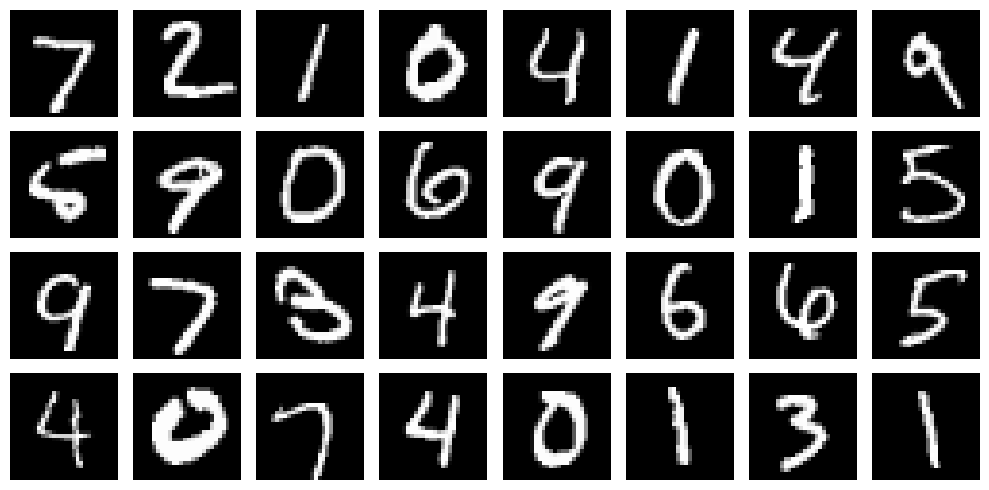

In [ ]:
# Display a grid of the original test images.
# 'x' holds a batch of original test images obtained from the test_loader.
show_images(x)

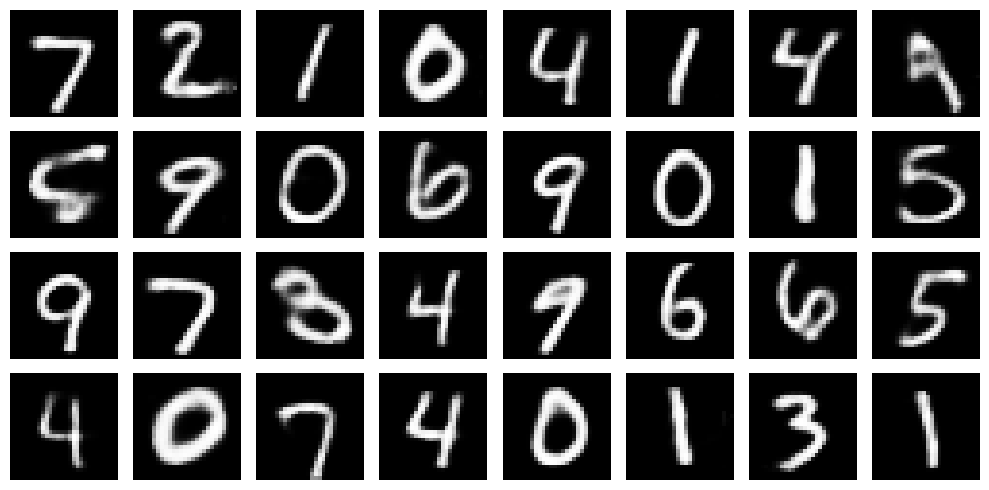

In [ ]:
# Display a grid of the reconstructed images generated by the VAE.
# 'x_hat' holds the reconstructed images corresponding to the input 'x'.
show_images(x_hat)

### Step 6. Generate image from noise vector

**Please note that this is not the correct generative process.**

* Even if we don't know exact p(z|x), we can generate images from noise, since the loss function of training VAE regulates the q(z|x) (simple and tractable posteriors) must close enough to N(0, I). If q(z|x) is close to N(0, I) "enough"(but not tightly close due to posterior collapse problem), N(0, I) may replace the encoder of VAE.

* To show this, I just tested with a noise vector sampled from N(0, I) similar with Generative Adversarial Network.

In [ ]:
# Generate new images from random noise in the latent space.

# Disable gradient calculations as we are only performing inference (generation).
with torch.no_grad():
    # Sample a batch of random noise vectors from a standard normal distribution.
    # The size of the noise vector matches the latent_dim.
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    # Pass the noise vectors through the decoder to generate images.
    # The decoder transforms the latent space vectors into image-like data.
    generated_images = decoder(noise)

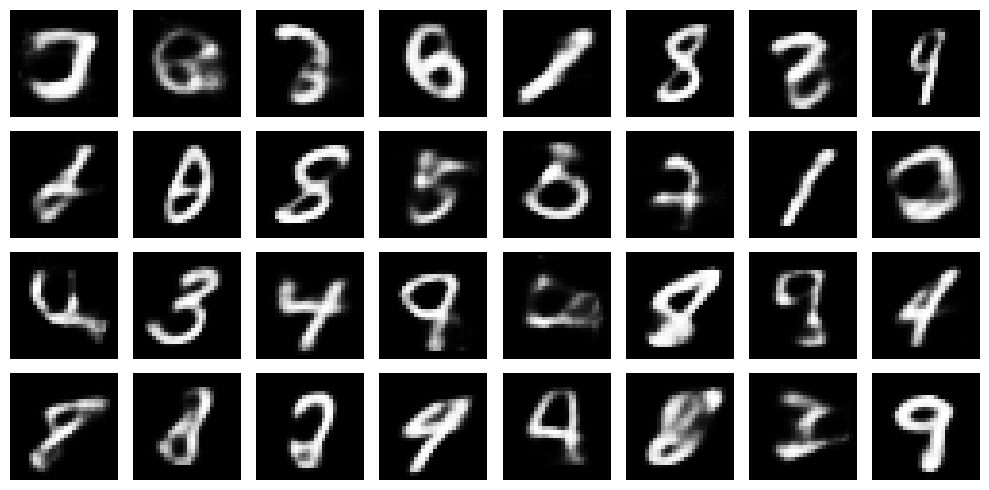

In [ ]:
# Display the images that were generated from random noise.
# These images demonstrate the generative capability of the VAE, as they are not reconstructions
# of existing inputs but entirely new samples from the learned latent space distribution.
show_images(generated_images)